# Hierarchical linear regression in `numpyro`

Let's see an initial demonstration of *gradient based inference* using the *probabilistic programming language* `numpyro`.

This demonstration shows linear regression, where we fit several linear datasets simultaneously. *Hierarchical* means that we don't treat the datasets independently, but instead we model the relations between the datasets.

In [2]:
import numpy as np
np.random.seed(301288)
from scipy import stats
import matplotlib.pyplot as plt

## Generate some mock data

Let's make some mock data for $N$ straight lines, where each line $i=1,...,N$ has it's own gradient $m_i$ and slope $c_i$, i.e.

$$
y_{ij} = m_i x_{ij} + c_i
$$

and the gradients and slopes are sampled from normal distributions with specified means $\mu$ and scale $\tau$, i.e.

$$
m_i \sim \mathcal{N}(\mu_m, \tau_m)
$$

$$
c_i \sim \mathcal{N}(\mu_c, \tau_c)
$$

The following function generates this mock data:

In [3]:
def get_data(mu_m = 1.5,
             tau_m = 0.5,
             mu_c = -3.,
             tau_c = 2,
             sig_y = 0.5,
             N = 50,
             n_dat = 300):
    '''generate mock data for N straight lines according to model:
    
    For i = 1, ..., N:
    m_i ~ N(mu_m, tau_m)
    c_i ~ N(mu_c, tau_c)
    For j = 1, ..., n_dat:
        x_{ij} ~ Unif(-3, 3) 
        y^{obs}_{ij} ~ Norm(m_i*x_{ij}+c_i, sig_y)
    
    ''' 
    nrm_m = stats.norm(mu_m, tau_m)
    nrm_c = stats.norm(mu_c, tau_c)
    m = nrm_m.rvs(N)
    c = nrm_c.rvs(N)
    unif_x = stats.uniform(loc=-3, scale=6)
    x = unif_x.rvs((n_dat, N))
    nrm_y_obs = stats.norm(m*x + c, sig_y)
    y_obs = nrm_y_obs.rvs()
    true_pars = {
        'mu_m':mu_m, 
        'tau_m':tau_m, 
        'mu_c':mu_c, 
        'tau_c':tau_c, 
    }
    data = {'N':N, 'n_dat':n_dat, 'x':x, 'y_obs':y_obs, 'sig_y':sig_y}
    return true_pars, data

In [4]:
def plot_data(data, samples=None):
    fig, ax = plt.subplots(5, 10, figsize=(10, 5), sharex=True, sharey=True)
    ax = np.ravel(ax)
    for i, ax0 in enumerate(ax):
        ax0.plot(data['x'][:,i], data['y_obs'][:,i], '.')
        ax0.axhline(0, ls='--', color='k', alpha=0.2)
        ax0.axvline(0, ls='--', color='k', alpha=0.2)
    if samples is not None:
        x = np.linspace(-3,3,100)
        for i, ax0 in enumerate(ax):
            y_smp = samples['m'][:,i]*x[:,np.newaxis] + samples['c'][:,i]
            y_lo, y_hi = np.percentile(y_smp, [0.5,99.5], 1)
            ax0.fill_between(x, y_lo, y_hi, color='C1')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    return fig

## Look at the data

In [5]:
true_pars, data = get_data()

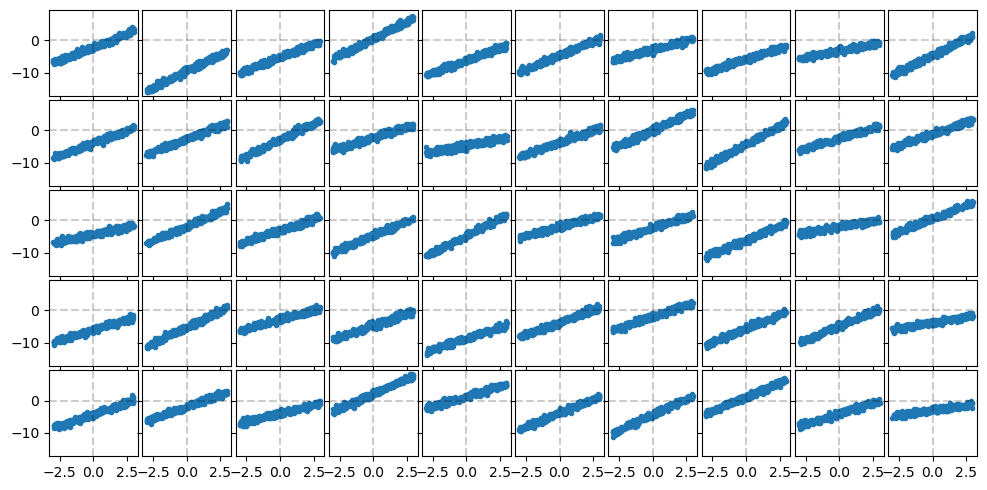

In [6]:
_ = plot_data(data)

## Define a probabilistic model in `numpyro` to fit this data

In [7]:
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/Users/yhra/miniconda3/envs/BATIP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def model(data):
    # define priors on mu_m, tau_m, mu_c, tau_c
    prior_mu_m = dist.Normal(0, 3)
    prior_tau_m = dist.HalfNormal(3)
    prior_mu_c = dist.Normal(0, 3)
    prior_tau_c = dist.HalfNormal(3)
    # sample mu_m, tau_m, mu_c, tau_c from their priors
    mu_m = numpyro.sample('mu_m', prior_mu_m)
    tau_m = numpyro.sample('tau_m', prior_tau_m)
    mu_c = numpyro.sample('mu_c', prior_mu_c)
    tau_c = numpyro.sample('tau_c', prior_tau_c)
    with numpyro.plate('N', data['N']):
        m = numpyro.sample('m', dist.Normal(mu_m, tau_m))
        c = numpyro.sample('c', dist.Normal(mu_c, tau_c))
        with numpyro.plate('n_dat', data['n_dat']):
            # sample the data
            y_obs = numpyro.sample(
                'y_obs', 
                dist.Normal(m*data['x']+c, data['sig_y']),
                obs=data['y_obs'])
    return

## Draw the Bayesian Network for this model

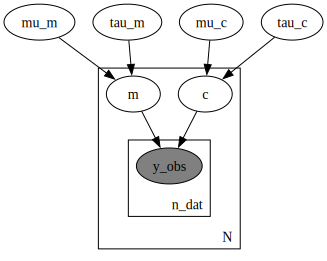

In [10]:
numpyro.render_model(model,  model_args=(data,))

## Run NUTS

This is a *gradient-based inference algorithm* for MCMC sampling.

In [11]:
# Start from this source of randomness
rng_key = random.PRNGKey(0)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key, data)

sample: 100%|██████████| 1500/1500 [00:01<00:00, 1084.78it/s, 7 steps of size 4.46e-01. acc. prob=0.85]


In [12]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      c[0]     -2.09      0.03     -2.09     -2.14     -2.04   1174.06      1.00
      c[1]     -9.51      0.03     -9.51     -9.56     -9.47   1458.22      1.00
      c[2]     -5.23      0.03     -5.23     -5.27     -5.18   1251.30      1.00
      c[3]      0.47      0.03      0.47      0.43      0.52   1001.93      1.00
      c[4]     -6.18      0.03     -6.18     -6.23     -6.13   1118.25      1.00
      c[5]     -4.61      0.03     -4.61     -4.65     -4.56   1505.66      1.00
      c[6]     -2.93      0.03     -2.93     -2.98     -2.88   1134.15      1.00
      c[7]     -5.82      0.03     -5.82     -5.87     -5.78   1262.89      1.00
      c[8]     -3.27      0.03     -3.27     -3.32     -3.22    999.21      1.00
      c[9]     -4.61      0.03     -4.61     -4.65     -4.56   1801.27      1.00
     c[10]     -3.87      0.03     -3.87     -3.92     -3.82    919.05      1.00
     c[11]     -2.64      0

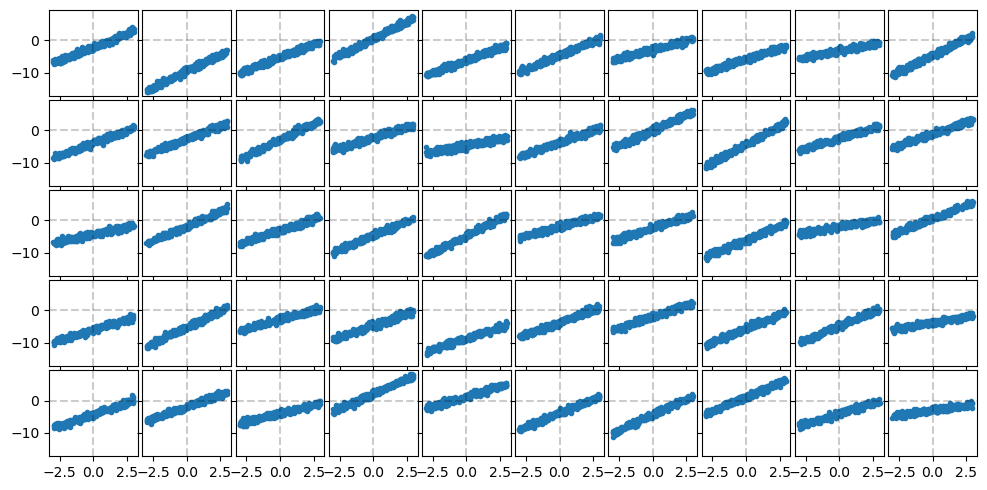

In [13]:
_ = plot_data(data, samples=mcmc.get_samples())

## Look at the posterior samples

In [16]:
import arviz as az

In [17]:
az_mcmc = az.from_numpyro(mcmc)

In [18]:
az_mcmc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

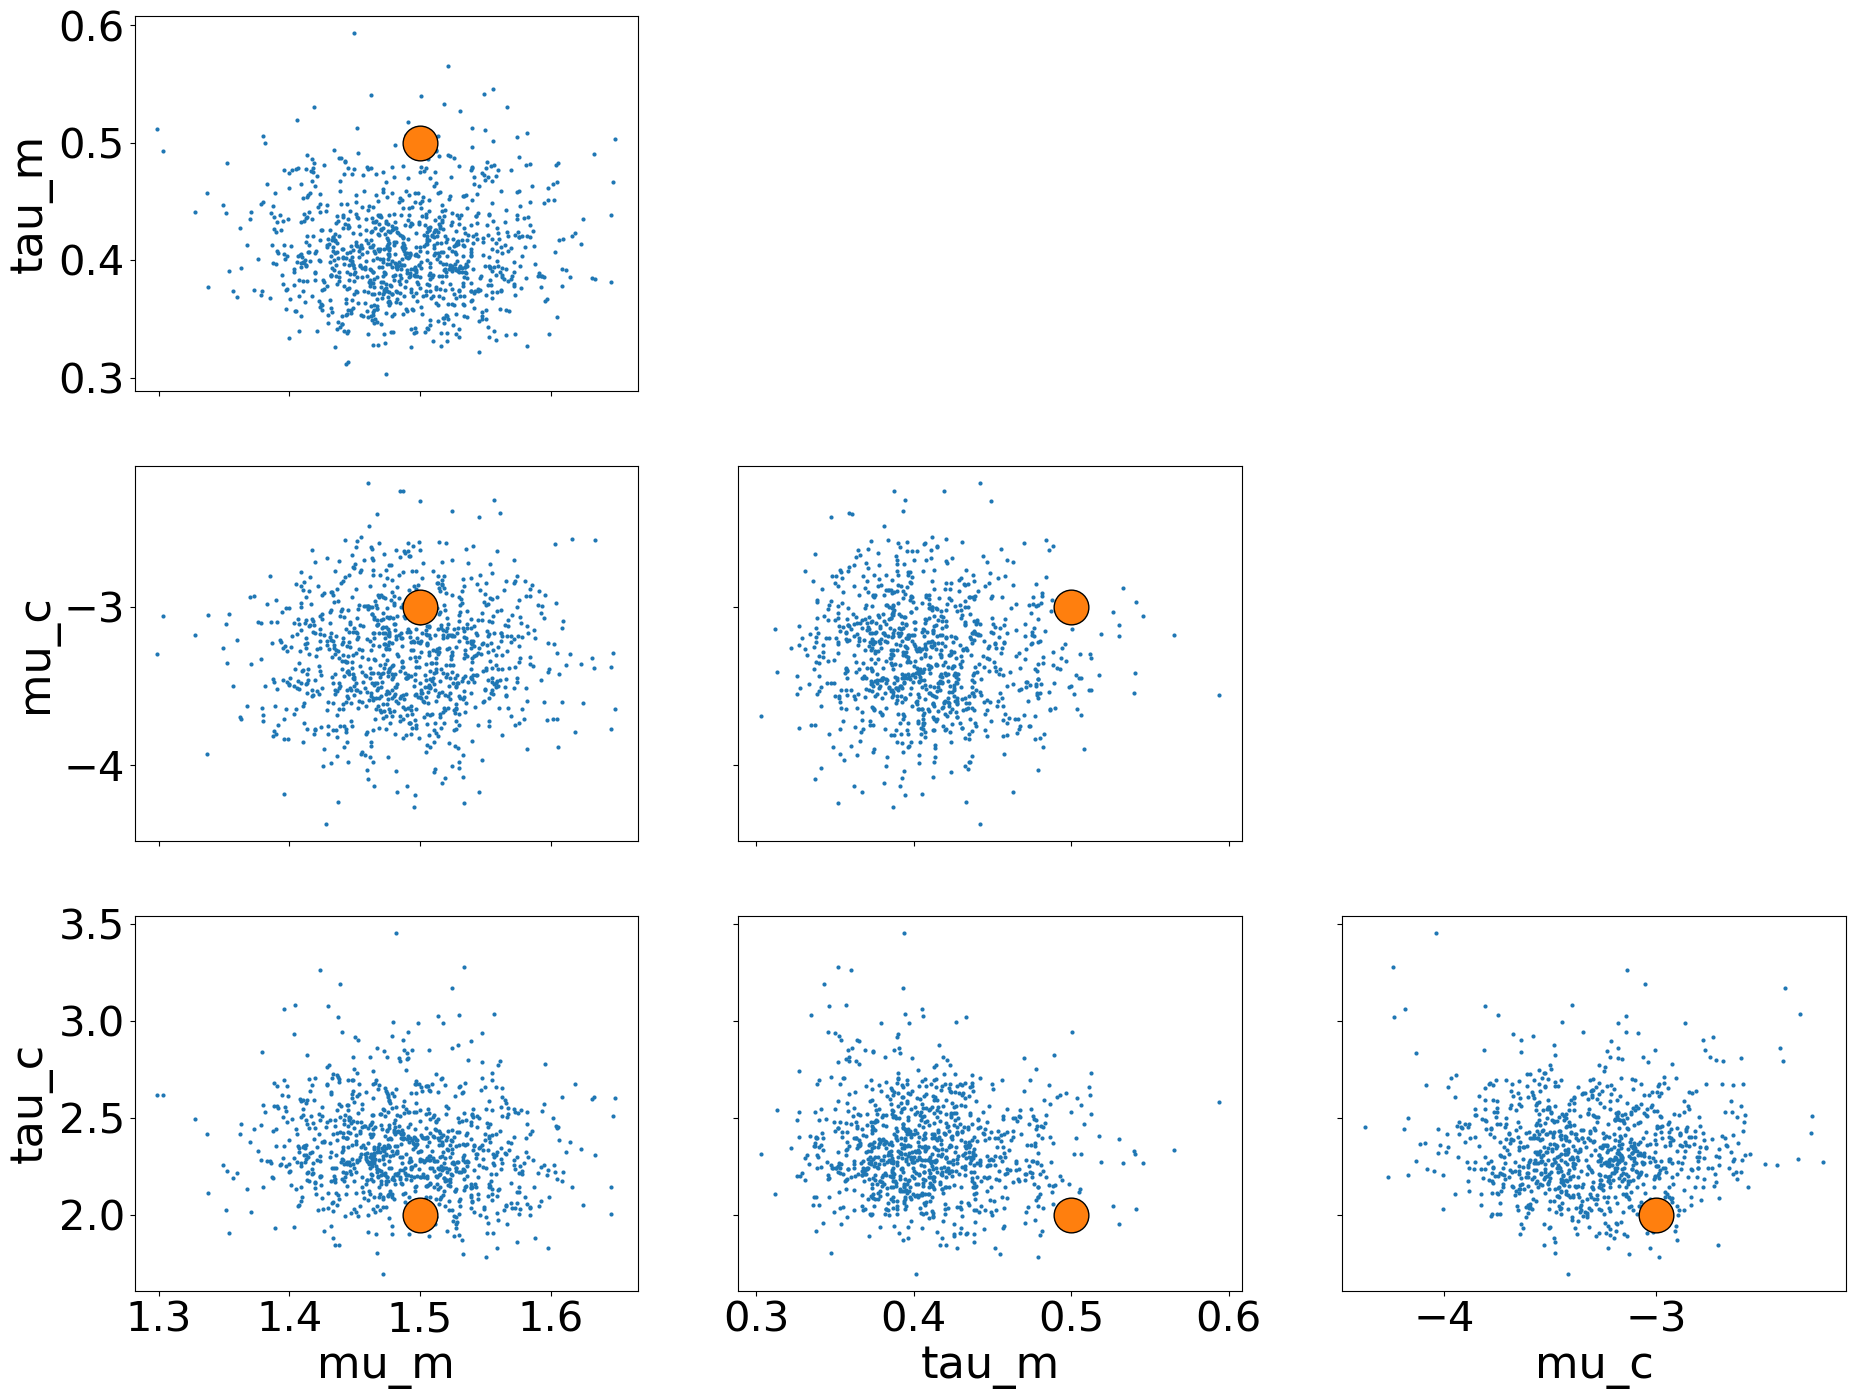

In [19]:
_ = az.plot_pair(
    az_mcmc,
    var_names=['mu_m', 'tau_m', 'mu_c', 'tau_c'],
    reference_values=true_pars,
    reference_values_kwargs={'color':'C1', 'markersize':25},
    textsize=30)

The true values (orange) lie within the posterior samples (blue) - i.e. the inference has succeessfully estimates the truth.

The with of the posterior gives us an estimate of the uncertainty in our inference.